# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Head
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Tipos de datos
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [5]:
# Datos nulos
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [ ]:
# Estadística básica
customers.describe()

In [ ]:
# Colinealidad

# Hacer un heatmap
# Compute the correlation matrix
corr = customers.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

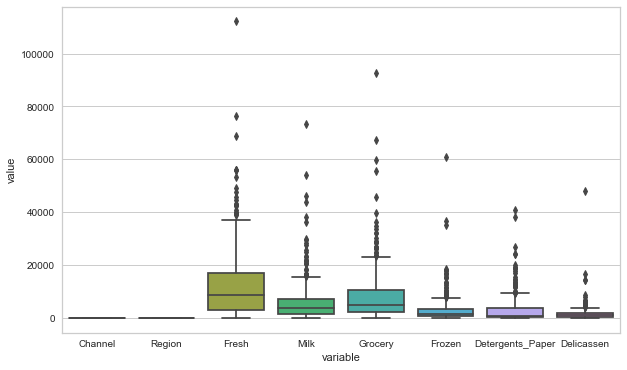

In [43]:
# Outliers-> Sacar unos boxplots 
f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(customers))

(array([419.,  17.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.0000e+00, 4.7970e+03, 9.5910e+03, 1.4385e+04, 1.9179e+04,
        2.3973e+04, 2.8767e+04, 3.3561e+04, 3.8355e+04, 4.3149e+04,
        4.7943e+04]),
 <a list of 10 Patch objects>)

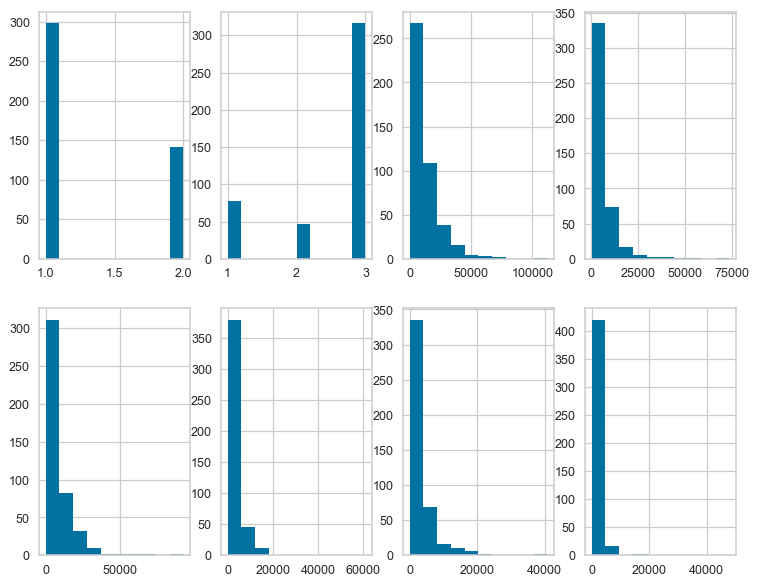

In [46]:
# Histogramas de cada compra
fig,axes = plt.subplots(figsize = (10,8),nrows = 2, ncols = 4, dpi=90)
plt.sca(axes[0,0])
plt.hist(customers.Channel)
plt.sca(axes[0,1])
plt.hist(customers.Region)
plt.sca(axes[0,2])
plt.hist(customers.Fresh)
plt.sca(axes[0,3])
plt.hist(customers.Milk)
plt.sca(axes[1,0])
plt.hist(customers.Grocery)
plt.sca(axes[1,1])
plt.hist(customers.Frozen)
plt.sca(axes[1,2])
plt.hist(customers.Detergents_Paper)
plt.sca(axes[1,3])
plt.hist(customers.Delicassen)


##### Observaciones

* *Las variables de Channel y Region son categóricas, por tanto hay que cambiarlas a string.*
* *Hay algunas compras que podríamos considerar outliers en en las variables Fresh, Milk, Grocery, Frozen y Delicassen.*
* *Hay colinealidad entre grocery y detergent_paper, por tanto eliminaremos una de ellas.*
* *La distribución de los histogramas confirman la ley de Paretto.*


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [6]:
# Convertir las columnas channel y region a categóricas
customers[["Channel", "Region"]] = customers[["Channel", "Region"]].astype('category')

In [7]:
# Quitar la columna Detergents_paper
customers_cl = customers.drop(columns="Detergents_Paper")

In [8]:
# Eliminar outliers
from scipy import stats
# Extraer las variables numéricas
numerical = customers_cl[["Fresh","Milk","Grocery","Frozen","Delicassen"]]
customers_cl = customers_cl[(np.abs(stats.zscore(numerical)) < 3).all(axis=1)]
# FUENTE:https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame)
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

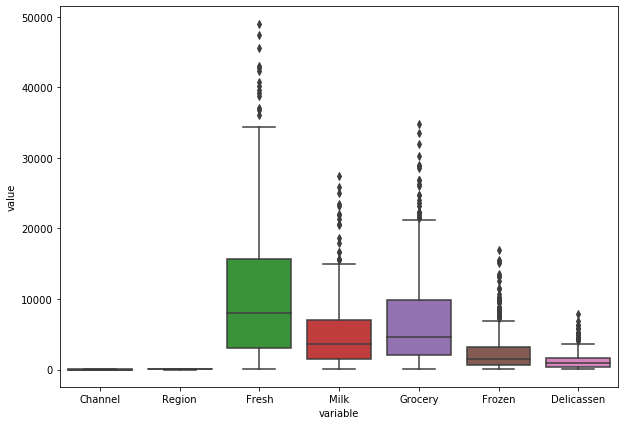

In [9]:
# Comprobar que fue bien
f, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x="variable", y="value", data=pd.melt(customers_cl))

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [10]:
# Your import here:
from sklearn.preprocessing import StandardScaler
# Your code here:
scaler = StandardScaler()
customers_scale = pd.DataFrame(scaler.fit_transform(customers_cl), columns= customers_cl.columns)
customers_scale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen
0,1.466804,0.589455,0.201488,0.985150,0.093115,-0.805750,0.065492
1,1.466804,0.589455,-0.371949,1.017527,0.393580,-0.274447,0.418021
2,1.466804,0.589455,-0.443884,0.806868,0.111529,-0.053757,5.301918
3,-0.681754,0.589455,0.262388,-0.793473,-0.406911,1.318777,0.427679
4,1.466804,0.589455,1.217777,0.092475,0.038771,0.464504,3.161793
...,...,...,...,...,...,...,...
411,-0.681754,0.589455,1.942033,1.488673,1.360547,3.628987,0.762501
412,-0.681754,0.589455,2.915303,-0.744067,-0.924454,0.668720,0.876792
413,1.466804,0.589455,0.391749,2.211265,3.488804,-0.729212,0.491263
414,-0.681754,0.589455,-0.041599,-0.628435,-0.704682,-0.522938,0.698917


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [19]:
# Your code here:
model = KMeans(n_clusters=8)
model_labels = model.fit_predict(customers_scale)
customers_cl["labels"] = model_labels

Count the values in `labels`.

In [20]:
# Your code here:
customers_cl.labels.value_counts()

1    130
6     75
0     67
3     39
2     37
5     35
4     22
7     11
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [21]:
# Your code here
from sklearn.cluster import DBSCAN
model_DBSCAN = DBSCAN(eps=0.5).fit(customers_scale)


In [22]:
customers_cl["labels_DBSCAN"] = model_DBSCAN.labels_

Count the values in `labels_DBSCAN`.

In [23]:
# Your code here
customers_cl["labels_DBSCAN"].value_counts()

-1    331
 0     78
 1      7
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

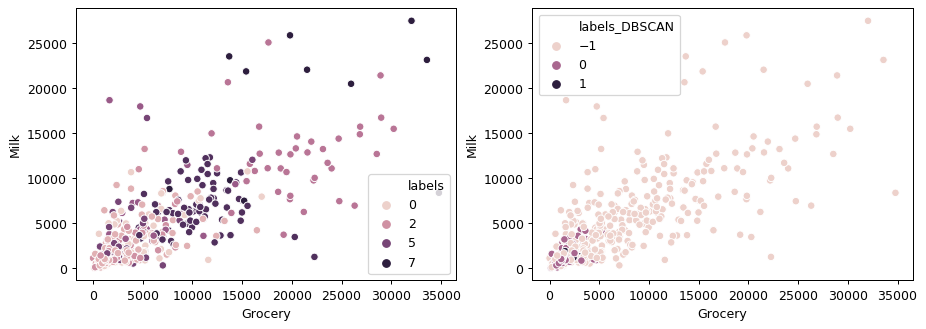

In [28]:
# Your code here:
fig,axes = plt.subplots(figsize = (12,4),nrows = 1, ncols = 2, dpi=90)
plt.sca(axes[0])
sns.scatterplot(x="Grocery", y="Milk", data=customers_cl, hue = "labels")
plt.sca(axes[1])
sns.scatterplot(x="Grocery", y="Milk", data=customers_cl, hue = "labels_DBSCAN")

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

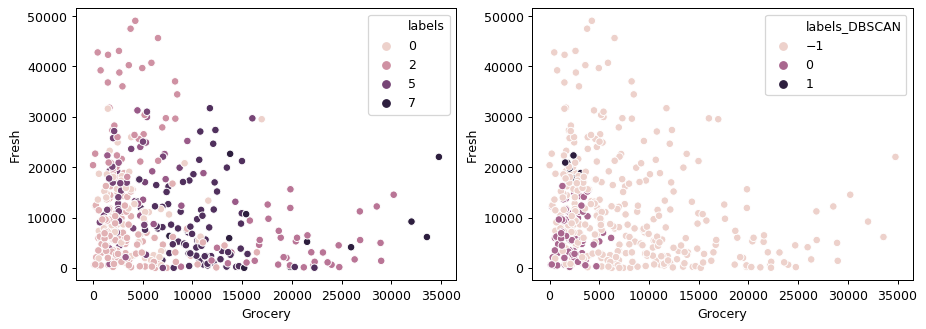

In [29]:
fig,axes = plt.subplots(figsize = (12,4),nrows = 1, ncols = 2, dpi=90)
plt.sca(axes[0])
sns.scatterplot(x="Grocery", y="Fresh", data=customers_cl, hue = "labels")
plt.sca(axes[1])
sns.scatterplot(x="Grocery", y="Fresh", data=customers_cl, hue = "labels_DBSCAN")


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

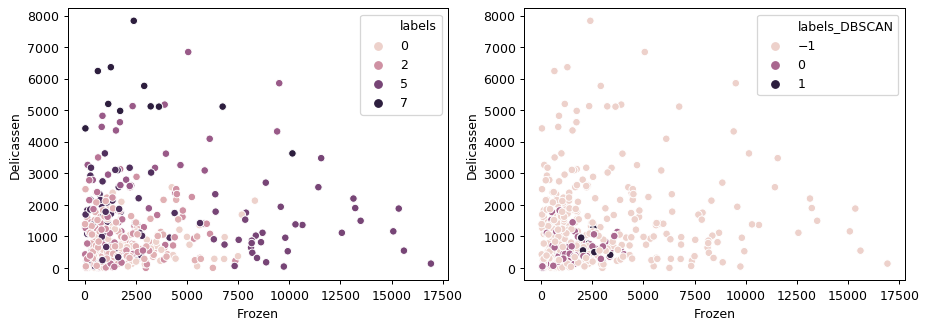

In [30]:
fig,axes = plt.subplots(figsize = (12,4),nrows = 1, ncols = 2, dpi=90)
plt.sca(axes[0])
sns.scatterplot(x="Frozen", y="Delicassen", data=customers_cl, hue = "labels")
plt.sca(axes[1])
sns.scatterplot(x="Frozen", y="Delicassen", data=customers_cl, hue = "labels_DBSCAN")

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [31]:
customers_cl.groupby(["labels", "labels_DBSCAN"]).mean()

Fresh          Milk       Grocery       Frozen  \
labels labels_DBSCAN                                                          
0      -1             10059.074627   2848.776119   3923.238806  2530.746269   
1      -1              5924.489796   3669.632653   5007.000000  1663.612245   
        0              6197.884615   1727.551282   2156.884615  1420.756410   
        1             18219.000000   1272.333333   2536.333333  2978.000000   
2      -1             32369.878788   3336.363636   3885.666667  2721.424242   
        1             20968.250000   1886.750000   1942.000000  2231.750000   
3      -1              4717.743590  12322.384615  20468.564103  1377.358974   
4      -1             15580.454545   6112.909091   5554.045455  3292.363636   
5      -1             14912.542857   3636.600000   3753.714286  9863.428571   
6      -1              8725.266667   6659.960000  10416.720000  1209.853333   
7      -1              8406.818182  18077.454545  21226.909091  3087.636364   

                       Delicassen  
labels labels_DBSCAN               
0      -1              841.179104  
1      -1              966.918367  
        0              594.525641  
        1              622.666667  
2      -1             1120.303030  
        1              698.500000  
3      -1             1230.538462  
4      -1             3841.409091  
5      -1             1232.457143  
6      -1             1273.400000  
7      -1             5442.909091

Which algorithm appears to perform better?

*K means, pero porque el otro algoritmo sólo ha conseguido separar 3 clases.*

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

/home/lee/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f890239bbb0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=False)

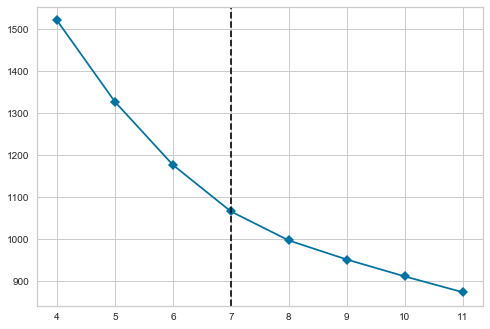

In [35]:
 # Calcular el número óptimo mediante KelbowVisualizaer
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)

visualizer.fit(customers_scale)

Parece que para los datos de customers (limpios de outliers, estandarizados y sin la columna de detergent_paper), el número óptimo de clusters es 7.

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here